# Nietzsche Next
- systematically evaluating of predictive accuracy of autocomplete model


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, TimeDistributed, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import re
import unicodedata
import os
from multiprocessing import Pool, cpu_count

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

# load character mappings
with open("/content/drive/MyDrive/autocomplete/data/char_mappings.pkl", "rb") as f:
    mappings = pickle.load(f)

char_to_index = mappings['char_to_index']
index_to_char = mappings['index_to_char']
vocab_size = mappings['vocab_size']

# load cleaned training and testing data
with open("/content/drive/MyDrive/autocomplete/data/nietzsche_train_clean.txt", "r") as f:
    nietzsche_train_clean = f.read()

with open("/content/drive/MyDrive/autocomplete/data/nietzsche_test_clean.txt", "r") as f:
    nietzsche_test_clean = f.read()

print(f"Vocabulary size: {vocab_size}")
print(f"Sample training data: {nietzsche_train_clean[:100]}")
print(f"Sample testing data: {nietzsche_test_clean[:100]}")


In [ ]:
import numpy as np

# load numpy arrays
test_sequences_np = np.load("/content/drive/MyDrive/autocomplete/data/test_sequences.npy")
test_labels_np = np.load("/content/drive/MyDrive/autocomplete/data/test_labels.npy")

# convert numpy arrays back to lists
train_sequences = train_sequences_np.tolist()
train_labels = train_labels_np.tolist()
test_sequences = test_sequences_np.tolist()
test_labels = test_labels_np.tolist()

print(f"First training sequence: {train_sequences[0]}")
print(f"First training label: {train_labels[0]}")
print(f"First testing sequence: {test_sequences[0]}")
print(f"First testing label: {test_labels[0]}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

sequence_length = 80
step = 1

# convert data to TensorFlow datasets
test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

# define one-hot encoding function for TPU
def one_hot_encode(x, y):
    x = tf.convert_to_tensor(x)
    y = tf.one_hot(y, depth=vocab_size)  # TPU-friendly one-hot encoding
    return x, y


# Batch, shuffle, and optimize dataset
batch_size = 2048  # TPUs handle larger batch sizes more effectively

test_data = (test_data
             .batch(batch_size, drop_remainder=True)
             .map(one_hot_encode)
             .prefetch(tf.data.AUTOTUNE))


In [ ]:
from keras.layers import TFSMLayer

model_layer = TFSMLayer('/content/drive/MyDrive/nietzsche_model_v04_1_tf', call_endpoint='serving_default')


In [ ]:
for sample, _ in test_data.take(1):  # Take one batch to inspect shape
    input_shape = sample.shape
    print("Input shape from dataset:", input_shape)
    break


Input shape from dataset: (2048, 80)


In [ ]:
# wrap layer in simple model to make predictions
#inputs = tf.keras.Input(shape=(input_shape))  # Set input_shape based on your model
inputs = tf.keras.Input(shape=(80,))  # Remove additional dimension
outputs = model_layer(inputs)
prediction_model = tf.keras.Model(inputs, outputs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# assess prediction accuracy

# select sequences from test set
select_sequences = np.arange(0,len(test_sequences),80)

pred_acc_1 = [] # prediction based on context
pred_acc_2 = [] # prediction based on context plus first character

# loop over sequences, one sequence after another
for seq_num in select_sequences: # len(test_sequences)

  # flag last unambiguously complete word (the one between second-to-last and last " ")
  whitespace_locs = [i for i, e in enumerate(test_sequences[seq_num]) if e == 0]
  last_word_start = whitespace_locs[len(whitespace_locs)-2]
  last_word_stop = whitespace_locs[len(whitespace_locs)-1]
  word_targ_idx = test_sequences[seq_num][last_word_start+1:last_word_stop]

  # cut and pad sequence
  gap_to_full_seq = sequence_length - len(test_sequences[seq_num][:last_word_start+1])
  padding = [0] * gap_to_full_seq
  padded_seq1 = padding + test_sequences[seq_num][:last_word_start+1] # sequence before word
  padded_seq2 = padding + test_sequences[seq_num][1:last_word_start+2] # sequence before word plus 1st character of word

  # predict word from context
  word_pred_idx_1 = []
  seq_2_be_predicted = np.array(padded_seq1).reshape(1, 80)  # Reshape to (1, 80) for batch compatibility
  prob_dict = prediction_model.predict(seq_2_be_predicted, verbose=0)
  # list(prob_dict.values())[0].shape # list w. only 1 element; returns (1, 80, 60)
  # pred probs for last character in sequence:
  pred_probs = list(prob_dict.values())[0][:,sequence_length-1,:]
  # still a 1 x vocab_size object:
  pred_probs = pred_probs[0]
  pred_index = np.argmax(pred_probs) # returns the indices of the maximum values along an axis
  word_pred_idx_1.append(pred_index)

  while pred_index != 0:
      padded_seq1.append(pred_index)
      padded_seq1 = padded_seq1[1:]

      seq_2_be_predicted = np.array(padded_seq1).reshape(1, 80)
      prob_dict = prediction_model.predict(seq_2_be_predicted, verbose=0)
      pred_probs = list(prob_dict.values())[0][:,sequence_length-1,:]
      pred_probs = pred_probs[0]
      pred_index = np.argmax(pred_probs)
      #print(word_pred_idx)
      if pred_index == 0:
          break
      word_pred_idx_1.append(pred_index)


  # predict word from context plus first character of word
  word_pred_idx_2 = [padded_seq2[len(padded_seq2)-1]] # first character is known

  seq_2_be_predicted = np.array(padded_seq2).reshape(1, 80)  # Reshape to (1, 80) for batch compatibility
  prob_dict = prediction_model.predict(seq_2_be_predicted, verbose=0)
  # list(prob_dict.values())[0].shape # list w. only 1 element; returns (1, 80, 60)
  # pred probs for last character in sequence:
  pred_probs = list(prob_dict.values())[0][:,sequence_length-1,:]
  # still a 1 x vocab_size object:
  pred_probs = pred_probs[0]
  pred_index = np.argmax(pred_probs) # Returns the indices of the maximum values along an axis.
  word_pred_idx_2.append(pred_index)

  while pred_index != 0:
      padded_seq2.append(pred_index)
      padded_seq2 = padded_seq2[1:]

      seq_2_be_predicted = np.array(padded_seq2).reshape(1, 80)
      prob_dict = prediction_model.predict(seq_2_be_predicted, verbose=0)
      pred_probs = list(prob_dict.values())[0][:,sequence_length-1,:]
      pred_probs = pred_probs[0]
      pred_index = np.argmax(pred_probs)

      if pred_index == 0:
          break
      word_pred_idx_2.append(pred_index)

  # validate against targets
  # return true if there is a (partial) match: allow incomplete predictions a la sinful -> sinfulness
  val1 = word_pred_idx_1 == word_targ_idx[:len(word_pred_idx_1)]
  val2 = word_pred_idx_2 == word_targ_idx[:len(word_pred_idx_2)]

  pred_acc_1.append(val1)
  pred_acc_2.append(val2)



In [ ]:
print(np.unique(pred_acc_1, return_counts=True))
print(np.unique(pred_acc_2, return_counts=True))
# accuracy rates of ~12-18% and ~30-38% respectively

(array([False,  True]), array([6103, 1278]))
(array([False,  True]), array([4696, 2685]))


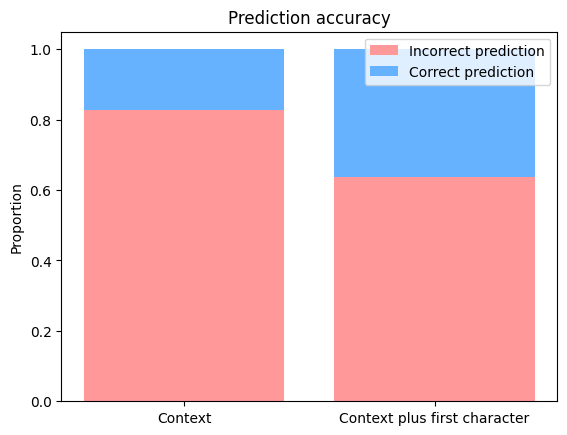

In [ ]:
from matplotlib import pyplot

proportions1 = np.unique(pred_acc_1, return_counts=True)[1] / len(pred_acc_1)
proportions2 = np.unique(pred_acc_2, return_counts=True)[1] / len(pred_acc_2)

data = np.array([proportions1, proportions2]).T  # Transpose for stacking

labels = ['Incorrect prediction' ,'Correct prediction']
colors = ['#FF9999','#66B2FF']

fig, ax = pyplot.subplots()
ax.bar(['Context', 'Context plus first character'], data[0], label='False', color=colors[0])
ax.bar(['Context', 'Context plus first character'], data[1], bottom=data[0], label='True', color=colors[1])

ax.set_ylabel('Proportion')
ax.set_title('Prediction accuracy')
ax.legend(labels)

pyplot.show()

In [ ]:
print("ground truth: ", [index_to_char[idx] for idx in word_targ_idx])
print("prediction (context-based)", [index_to_char[idx] for idx in word_pred_idx_1])
print("prediction (using first letter)", [index_to_char[idx] for idx in word_pred_idx_2])

ground truth:  ['m', 'a', 'k', 'e']
prediction (context-based) ['t', 'h', 'e']
prediction (using first letter) ['m', 'a', 'k', 'e']
